# This notebook contains the whole code with model selection and tests

## Extra class for colourful output

In [1]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Part 1. Model selection

### Import data

The main dataset was loaded from [Kaggle](https://www.kaggle.com/datasets/nathanlauga/nba-games/data). However, I added 2 extra files with season schedule (`season_schedule.csv`) and Play-Off teams for given seasons (`play_off_teams.csv`).

#### Games information

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

df_games = pd.read_csv('data/games.csv').drop(["TEAM_ID_home", "TEAM_ID_away"], axis=1)
df_games = df_games.loc[df_games["SEASON"] >= 2004]

scaler = MinMaxScaler()
cols_to_norm = ["HOME_TEAM_ID", "VISITOR_TEAM_ID"]
df_games.loc[:, cols_to_norm] = scaler.fit_transform(df_games.loc[:, cols_to_norm])
df_games

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,0.103448,0.758621,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,0.862069,0.931034,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,0.068966,0.413793,2022,114.0,0.482,0.786,0.313,22.0,37.0,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,0.620690,0.965517,2022,113.0,0.441,0.909,0.297,27.0,49.0,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,0.000000,0.137931,2022,108.0,0.429,1.000,0.378,22.0,47.0,110.0,0.500,0.773,0.292,20.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26646,2014-10-06,11400007,Final,0.000000,0.103448,2014,93.0,0.419,0.821,0.421,24.0,50.0,87.0,0.366,0.643,0.375,17.0,43.0,1
26647,2014-10-06,11400004,Final,0.137931,0.931034,2014,81.0,0.338,0.719,0.381,18.0,40.0,85.0,0.411,0.636,0.267,17.0,47.0,0
26648,2014-10-06,11400005,Final,0.344828,0.206897,2014,98.0,0.448,0.682,0.500,29.0,45.0,95.0,0.387,0.659,0.500,19.0,43.0,1
26649,2014-10-05,11400002,Final,0.827586,0.724138,2014,99.0,0.440,0.771,0.333,21.0,30.0,94.0,0.469,0.725,0.385,18.0,45.0,1


#### Teams information

In [3]:
df_teams = pd.read_csv('data/teams.csv')
df_teams.loc[:, ["TEAM_ID"]] = scaler.fit_transform(df_teams.loc[:, ["TEAM_ID"]])
df_teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,0.000000,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,0.034483,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,0.103448,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,0.137931,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,0.172414,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


#### Seasons dates

In [4]:
season_schedule = pd.read_csv("data/season_schedule.csv")
"""
SEASON: start year of the season, i.e. season 2004 is season 2004-2005
START: beginning date of regular mathces
END: beginning date of play-off
"""
season_schedule.head()

,SEASON,START,END
0,2004,2004-11-02,2005-04-23
1,2005,2005-11-01,2006-04-22
2,2006,2006-10-31,2007-04-21
3,2007,2007-10-30,2008-04-19
4,2008,2008-10-28,2009-04-18


### Test different models for all seasons

In [5]:
# which columns to use for predictions
useful_columns = ["HOME_TEAM_ID", "VISITOR_TEAM_ID",
                    'FG_PCT_home', 'FT_PCT_home',
                    'FG3_PCT_home', 'AST_home', 'REB_home',
                    'FG_PCT_away', 'FT_PCT_away',
                    'FG3_PCT_away', 'AST_away', 'REB_away',
                    'HOME_TEAM_WINS']

In [6]:
# hyper-parameters for models
dec_tree_params = {'criterion': ['gini', 'entropy'],
                   'splitter': ['best', 'random']}
rand_tree_params = {'criterion': ['gini', 'entropy'],
                    'n_estimators': [i for i in range(100, 501, 100)]}
svc_params = {'kernel': ['poly', 'rbf'],
              'degree': [i for i in range(3, 6)]}
knn_params = {'n_neighbors': [i for i in range(3, 6)],
              'weights': ['uniform', 'distance']}
nb_params = {'var_smoothing': np.linspace(1e-5, 1, 10)}
logreg_params = {'penalty': ['l2', None]}

# models to seelct from
models = {LogisticRegression: ('LogReg', logreg_params),
                 DecisionTreeClassifier: ('DecTree', dec_tree_params),
                 RandomForestClassifier: ('RandTree', rand_tree_params),
                 SVC: ('SVC', svc_params),
                 KNeighborsClassifier: ('KNN', knn_params),
                 GaussianNB: ('NaiveBayes', nb_params)}

metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}
test_results = {model: {metric: [] for metric in metrics.keys()} for model in models.keys()}

# iterate over data for each season and try different model
# to select which model performs better on average
for row in tqdm(season_schedule.iterrows()):
    season, _, __ = row[1].values
    X = df_games.loc[df_games["SEASON"] == season, useful_columns]
    cols_to_norm = ['AST_home', 'REB_home', 'AST_away', 'REB_away']
    
    X_train, X_test, y_train, y_test = train_test_split(X.drop(["HOME_TEAM_WINS"], axis=1),
                                                        X["HOME_TEAM_WINS"],
                                                        test_size=0.3,
                                                        random_state=42)
    X_train.loc[:, cols_to_norm] = scaler.fit_transform(X_train.loc[:, cols_to_norm])
    X_test.loc[:, cols_to_norm] = scaler.transform(X_test.loc[:, cols_to_norm])
    
    for model in models.keys():
        current_model = model()
        model_params = models[model][1]
        current_model = GridSearchCV(estimator=current_model,
                                         cv=3,
                                         param_grid=model_params,
                                         scoring='accuracy')
        current_model.fit(X_train, y_train)
        
        y_pred = current_model.predict(X_test)
        for metric_name, metric in metrics.items():
            test_results[model][metric_name].append(metric(y_test, y_pred))
    

13it [04:51, 22.41s/it]c:\Users\bugue\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
16it [06:01, 22.86s/it]c:\Users\bugue\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

### Plot bar diagram with average metrics results for each model

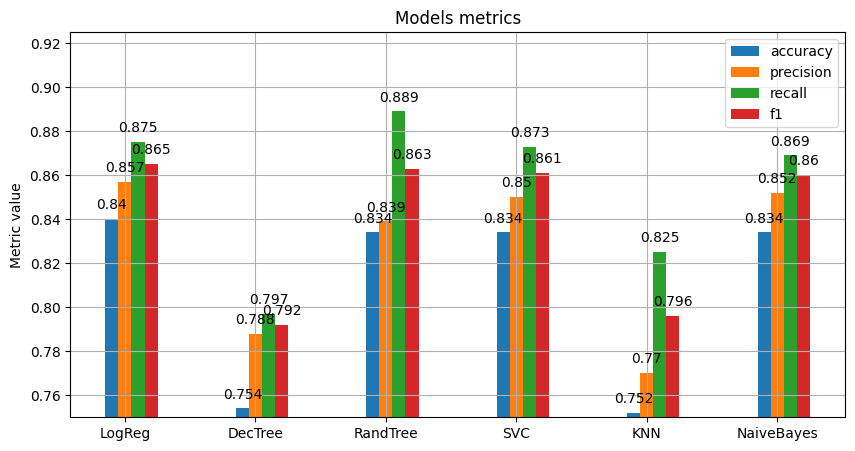

In [7]:
all_results = {metric_name: [] for metric_name in metrics.keys()}

for model, results in test_results.items():
    for metric, value in results.items():
        all_results[metric].append(np.array(value).mean())

x_loc = np.arange(len(models))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 5))

for attribute, measurement in all_results.items():
    offset = width * multiplier
    rects = ax.bar(x_loc + offset, np.round(measurement, 3), width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

ax.set_ylabel('Metric value')
ax.set_title('Models metrics')
ax.set_xticks(x_loc + width, [v[0] for v in models.values()])
ax.legend()
ax.grid()
ax.set_ylim(0.75, 0.925)

plt.show()

#### We can see that *Decision Tree* and *KNN* showed worst results in all metrics, hence we immediately drop them. *Random Decision Tree* demonstrated highest `recall` score compared to all models, but it showed worse results in other metrics, so we cannot immediately pick this model either. On average it looks like *Logistic regression* model showed one of the best results, therefore, let us use this model for the predictions.

## Part 2. Test model

### Compute average data for each team for a gven season

In [8]:
def compute_season_data(season_year:int=2018) -> pd.DataFrame:
    if 2004 > season_year > 2022:
        print("NO DATA FOR THIS SEASON")
        return
    
    season_start = season_schedule.loc[season_schedule["SEASON"] == season_year]["START"].iloc[0]
    season_end = season_schedule.loc[season_schedule["SEASON"] == season_year]["END"].iloc[0]
    season_data = df_games[(df_games["SEASON"] == season_year)
                           & (df_games["GAME_DATE_EST"] < season_end)].sort_values(by="GAME_DATE_EST")
    
    teams_data = df_teams[["TEAM_ID", "ABBREVIATION"]]
    teams_data.loc[:, ["SEASON"]] = season_year
    
    home_features = ['FG_PCT_home', 'FT_PCT_home',
                     'FG3_PCT_home', 'AST_home', 'REB_home']
    away_features = ['FG_PCT_away', 'FT_PCT_away',
                     'FG3_PCT_away', 'AST_away', 'REB_away']

    for team_row in teams_data.iterrows():
        idx, (team_id, _, __) = team_row[0], team_row[1].values
        home_data = season_data.loc[season_data["HOME_TEAM_ID"] == team_id, home_features]
        home_data = home_data.rename(columns={f: f[:-5] for f in home_features})

        away_data = season_data.loc[season_data["VISITOR_TEAM_ID"] == team_id, away_features]
        away_data = away_data.rename(columns={f: f[:-5] for f in away_features})
        
        temp_data = pd.concat([home_data, away_data])
        for col in temp_data.columns:
          teams_data.loc[idx, [col]] = temp_data.loc[:, [col]].mean()  
          
    cols_to_norm = ["AST", "REB"]
    teams_data.loc[:, cols_to_norm] = scaler.fit_transform(teams_data.loc[:, cols_to_norm])
    return teams_data


### Simulate one play-off series for 2 given teams

In [9]:
home_visitor_order = [True, True, False, False, True, False, True]
scale = 0.25

def simulate_play_off_round(team1: str, team2: str, ml_model, season_data: pd.DataFrame):
    if team1 == team2:
        print("YOU ENTERED THE SAME TEAMS")
        return
    
    team1_data = season_data.loc[season_data["ABBREVIATION"] == team1, :]
    team2_data = season_data.loc[season_data["ABBREVIATION"] == team2, :]
    
    home_team_id = []
    away_team_id = []

    fg_pct_home, ft_pct_home, fg3_pct_home = [], [], []
    ast_home, reb_home = [], []

    fg_pct_away, ft_pct_away, fg3_pct_away = [], [], []
    ast_away, reb_away = [], []
    for hv in home_visitor_order:
        if hv:
            home_team = team1_data
            away_team = team2_data
        else:
            home_team = team2_data
            away_team = team1_data
        
        home_team_id.append(home_team["TEAM_ID"].iloc[0])
        fg_pct_home.append(np.random.normal(home_team["FG_PCT"].iloc[0], scale=scale))
        ft_pct_home.append(np.random.normal(home_team["FT_PCT"].iloc[0], scale=scale))
        fg3_pct_home.append(np.random.normal(home_team["FG3_PCT"].iloc[0], scale=scale))
        ast_home.append(np.random.normal(home_team["AST"].iloc[0], scale=scale))
        reb_home.append(np.random.normal(home_team["REB"].iloc[0], scale=scale))
        
        away_team_id.append(away_team["TEAM_ID"].iloc[0])
        fg_pct_away.append(np.random.normal(away_team["FG_PCT"].iloc[0], scale=scale))
        ft_pct_away.append(np.random.normal(away_team["FT_PCT"].iloc[0], scale=scale))
        fg3_pct_away.append(np.random.normal(away_team["FG3_PCT"].iloc[0], scale=scale))
        ast_away.append(np.random.normal(away_team["AST"].iloc[0], scale=scale))
        reb_away.append(np.random.normal(away_team["REB"].iloc[0], scale=scale))
    
    cols = useful_columns
    data = {cols[0]: home_team_id, cols[1]: away_team_id,
            cols[2]: fg_pct_home, cols[3]: ft_pct_home, cols[4]: fg3_pct_home,
            cols[5]: ast_home, cols[6]: reb_home,
            cols[7]: fg_pct_away, cols[8]: ft_pct_away, cols[9]: fg3_pct_away,
            cols[10]: ast_away, cols[11]: reb_away}
    games = pd.DataFrame(data)
    results = ml_model.predict(games) 

    team1_wins, team2_wins = 0, 0
    for r, hv in zip(results, home_visitor_order):
        if r == 0:
            if hv:
                team2_wins += 1
            else:
                team1_wins += 1
        else:
            if hv:
                team1_wins += 1
            else:
                team2_wins += 1
        if team1_wins == 4:
            return team1
        elif team2_wins == 4:
            return team2

### Compare results between 2 teams in different seasons

In [10]:
def probability_to_win_round(team_pair: list, season_to_simulate: int, display_results=True) -> None:
    start = season_schedule.loc[season_schedule["SEASON"] == season_to_simulate, ["START", "END"]]["START"].iloc[0]
    end = season_schedule.loc[season_schedule["SEASON"] == season_to_simulate, ["START", "END"]]["END"].iloc[0]
    X = df_games.loc[(end > df_games["GAME_DATE_EST"]) &
                     (df_games["GAME_DATE_EST"] >= start), useful_columns]
    cols_to_norm = ['AST_home', 'REB_home',
                    'AST_away', 'REB_away']
    X.loc[:, cols_to_norm] = scaler.fit_transform(X.loc[:, cols_to_norm])
    X, y = X.drop(["HOME_TEAM_WINS"], axis=1), X["HOME_TEAM_WINS"]

    best_model = LogisticRegression()
        
    best_model.fit(X, y)
    season_data = compute_season_data(season_to_simulate)

    teams_results = {team: 0 for team in team_pair}
    num_of_sim = 100
    for i in range(num_of_sim):
        winner = simulate_play_off_round(team_pair[0], team_pair[1], best_model, season_data)
        teams_results[winner] += 1

    for t,w in teams_results.items():
        teams_results[t] = w / num_of_sim

    if display_results:
        print(f"Season {season_to_simulate}-{season_to_simulate+1}")
        for t,w in teams_results.items():
            print(f"{t} won {w*100:.3f}% of rounds")
        print()
    teams_results = dict(sorted(teams_results.items(), key=lambda item: item[1], reverse=True))
    return teams_results

year_list = [2015, 2019]
team_pair = ["LAL", "ATL"]
for season_to_simulate in year_list:
    probability_to_win_round(team_pair, season_to_simulate)

Season 2015-2016
LAL won 8.000% of rounds
ATL won 92.000% of rounds

Season 2019-2020
LAL won 87.000% of rounds
ATL won 13.000% of rounds



#### We can see that in different seasons different teams were stronger. Let's compare winning percantage from real data

In [11]:
df_standing = pd.read_csv("data/ranking.csv")
df_standing = df_standing.loc[:, ["TEAM_ID", "STANDINGSDATE", "TEAM", "W_PCT"]]
df_standing.loc[:, ["TEAM_ID"]] = scaler.fit_transform(df_standing.loc[:, ["TEAM_ID"]])
df_standing = pd.merge(df_standing, df_teams.loc[:, ["TEAM_ID", "ABBREVIATION"]], on="TEAM_ID")

print("Winning percentage")
for year in year_list:
    print(f"Season {year}-{year+1}")
    start = season_schedule.loc[season_schedule["SEASON"] == year]["START"].iloc[0]
    end = season_schedule.loc[season_schedule["SEASON"] == year]["END"].iloc[0]
    cur_season_data = df_standing.loc[df_standing["STANDINGSDATE"] == end].sort_values(by="TEAM")

    for t in team_pair:
        w_pct = cur_season_data.loc[cur_season_data["ABBREVIATION"] == t]["W_PCT"].iloc[0]
        print(f"{t}: {w_pct*100}%")
    print()

Winning percentage
Season 2015-2016
LAL: 20.7%
ATL: 58.5%

Season 2019-2020
LAL: 74.3%
ATL: 29.9%



#### We can see that in season 2015-2016 `LAL` won only 20% of their mathces while `ATL` won 58% percent of their matches, so probably `ATL` was stronger in that season, this proves our prediction above. However, in the season 2019-2020 winning percantage is other way around, which means `LAL` was stronger that season, as well as according to our prediction.

### Now let us simulate the entire play-off series for desired season

In [12]:
play_off_pairs = pd.read_csv('data/play_off_teams.csv')
play_off_pairs.head()

,SEASON,EAST_TEAMS,WEST_TEAMS,WINNER,RUNNER_UP
0,2004,"['DET', 'PHI', 'IND', 'BOS', 'MIA', 'BKN', 'WA...","['DAL', 'HOU', 'PHX', 'MEM', 'SAS', 'DEN', 'OK...",SAS,DET
1,2005,"['CLE', 'WAS', 'DET', 'MIL', 'MIA', 'CHI', 'BK...","['DAL', 'MEM', 'SAS', 'SAC', 'LAC', 'DEN', 'PH...",MIA,DAL
2,2006,"['CHI', 'MIA', 'DET', 'ORL', 'CLE', 'WAS', 'BK...","['GSW', 'DAL', 'UTA', 'HOU', 'PHX', 'LAL', 'SA...",SAS,CLE
3,2007,"['BOS', 'ATL', 'CLE', 'WAS', 'DET', 'PHI', 'OR...","['LAL', 'DEN', 'UTA', 'HOU', 'CHA', 'DAL', 'SA...",BOS,LAL
4,2008,"['ATL', 'MIA', 'CLE', 'DET', 'BOS', 'CHI', 'OR...","['DAL', 'SAS', 'DEN', 'CHA', 'HOU', 'POR', 'LA...",LAL,ORL


In [13]:
def simulate_entire_play_off(season, east_teams, west_teams, real_winner, runner_up, display_all_results=False):
    print(f"Simulating {season}-{season+1} Play-Off Finals")
    if display_all_results:
        print("\nEAST:")
    while len(east_teams) > 1:
        east_results = []
        for i in range(0, len(east_teams), 2):
            east_results.append(probability_to_win_round([east_teams[i], east_teams[i+1]], 
                                                        season, 
                                                        display_results=False))
        east_teams = [list(res.items())[0][0] for res in east_results]
        if display_all_results:
            for i in range(len(east_results)):
                winner = list(east_results[i].items())[0]
                loser = list(east_results[i].items())[1]
                print(f"{color.GREEN}{winner[0]}{color.END}({winner[1]:.2f}) defeated {color.RED}{loser[0]}{color.END}({loser[1]:.2f})")
            print()
    
    if display_all_results:
        print("\nWEST:")
    while len(west_teams) > 1:
        west_results = []
        for i in range(0, len(west_teams), 2):
            west_results.append(probability_to_win_round([west_teams[i], west_teams[i+1]], 
                                                        season, 
                                                        display_results=False))
        west_teams = [list(res.items())[0][0] for res in west_results]
        if display_all_results:
            for i in range(len(west_results)):
                winner = list(west_results[i].items())[0]
                loser = list(west_results[i].items())[1]
                print(f"{color.GREEN}{winner[0]}{color.END}({winner[1]:.2f}) defeated {color.RED}{loser[0]}{color.END}({loser[1]:.2f})")
            print()
    
    final_result = probability_to_win_round([east_teams[0], west_teams[0]], season, display_results=False)
    winner = list(final_result.items())[0]
    loser = list(final_result.items())[1]
    print(f"According to the prediction {color.GREEN}{winner[0]}{color.END}({winner[1]:.2f}) defeated {color.RED}{loser[0]}{color.END}({loser[1]:.2f})")
    print(f"While in real life {color.GREEN}{real_winner}{color.END} defeated {color.RED}{runner_up}{color.END}\n")
    # return winner

In [14]:
for i in range(1):
    some_row = play_off_pairs.sample(random_state=i+1)
    
    season, east_teams, west_teams, real_winner, runner_up = some_row.values[0]
    east_teams = [t[1:-1] for t in east_teams[1: -1].split(', ')]
    west_teams = [t[1:-1] for t in west_teams[1: -1].split(', ')]
    
    simulate_entire_play_off(season, east_teams, west_teams, real_winner, runner_up, display_all_results=True)

Simulating 2010-2011 Play-Off Finals

EAST:
ORL(0.69) defeated ATL(0.31)
CHI(0.99) defeated IND(0.01)
BOS(0.79) defeated NYK(0.21)
PHI(0.89) defeated MIA(0.11)

CHI(0.95) defeated ORL(0.05)
PHI(0.54) defeated BOS(0.46)

CHI(0.75) defeated PHI(0.25)


WEST:
DAL(0.99) defeated POR(0.01)
LAL(0.99) defeated CHA(0.01)
SAS(0.93) defeated MEM(0.07)
DEN(0.72) defeated OKC(0.28)

DAL(0.66) defeated LAL(0.34)
SAS(0.64) defeated DEN(0.36)

DAL(0.73) defeated SAS(0.27)

According to the prediction DAL(0.55) defeated CHI(0.45)
While in real life DAL defeated MIA



#### We can see that in some cases model makes correct prediction about winner but other finalist. In other cases the model makes incorrect predictions about both finalists. Concluding, the model may work properly but probably more tuning is required.